Regression based on Max's code, play with and clean (see week3 for one based on tutorials, not as good)

In [15]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import resolution_util as ru
import plot_util as pu
import ml_util as mu
import uproot as ur

from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor

import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler #this f'n standardizes data by removing the mean and scaling by the stddev

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [3]:
path = '/fast_scratch/atlas_images/v7/'
pp_file = ur.open(path+'piplus.root')
pp_tree = pp_file['ClusterTree']
branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']
pp = pd.DataFrame(pp_tree.arrays(expressions = branches, library='np'))

In [4]:
#define convenience columns

pp['clusterEoverCalib'] = pp.clusterE / pp.cluster_ENG_CALIB_TOT
pp['clusterEoverTruth'] = pp.clusterE / pp.truthE
pp['cluster_ENG_ALL'] = pp.cluster_ENG_CALIB_TOT + pp.cluster_ENG_CALIB_OUT_T + pp.cluster_ENG_CALIB_DEAD_TOT

# regression variables: define up here to make it easier for later swapping

pp['logE'] = np.log(pp.clusterE)
pp['logECalib'] = np.log(pp.cluster_ENG_CALIB_TOT)
pp['logECalibAll'] = np.log(pp.cluster_ENG_ALL)

# create scaler
scaler_e = StandardScaler()
scaler_cal = StandardScaler()
scaler_calAll = StandardScaler()
# fit and transform in one step
pp['s_logE'] = scaler_e.fit_transform(pp['logE'].to_numpy().reshape(-1,1))
pp['s_logECalib'] = scaler_cal.fit_transform(pp['logECalib'].to_numpy().reshape(-1,1))
pp['s_logECalibAll'] = scaler_calAll.fit_transform(pp['logECalibAll'].to_numpy().reshape(-1,1))


In [6]:
pp['s_logE'], pp['logE']

(0         2.196562
 1         0.884138
 2        -1.103210
 3         0.270568
 4        -1.052124
             ...   
 435962   -0.379634
 435963    0.314869
 435964    0.751148
 435965   -0.022703
 435966   -0.583985
 Name: s_logE, Length: 435967, dtype: float32,
 0         7.442252
 1         4.063764
 2        -1.052139
 3         2.484289
 4        -0.920629
             ...   
 435962    0.810517
 435963    2.598331
 435964    3.721415
 435965    1.729342
 435966    0.284469
 Name: logE, Length: 435967, dtype: float32)

In [9]:
# fun cleaning for EMProb
epsilon = 0.000000000001
pp['cluster_fixEM'] = pp.cluster_EM_PROBABILITY.replace(to_replace=0,value=epsilon)
pp['cluster_logEM'] = np.log(pp.cluster_fixEM)
scaler_EM = StandardScaler()
pp['s_logEM'] = scaler_EM.fit_transform(pp.cluster_logEM.to_numpy().reshape(-1,1))
scaler_eta = StandardScaler()
pp['s_eta'] = scaler_eta.fit_transform(pp.clusterEta.to_numpy().reshape(-1,1))
pp['logCenter'] = np.log(pp.cluster_CENTER_MAG)
scaler_center = StandardScaler()
pp['s_logCenter'] = scaler_center.fit_transform(pp.logCenter.to_numpy().reshape(-1,1))
scaler_density = StandardScaler()
pp['s_Density'] = scaler_density.fit_transform(pp.cluster_FIRST_ENG_DENS.to_numpy().reshape(-1,1))

In [10]:
# define convience sub-frames

pp['Single'] = pp.nCluster==1 # define a subset of events with only one cluster
mu.splitFrameTVT(pp, trainfrac = 0.7)          # define a train/test fraction of 70/20% (10% for val at this point)

EMB1_cells = mu.setupCells(pp_tree, 'EMB1') # implicitly flatten
EMB2_cells = mu.setupCells(pp_tree, 'EMB2')
EMB3_cells = mu.setupCells(pp_tree, 'EMB3') # implicitly flatten

TileBar0_cells = mu.setupCells(pp_tree, 'TileBar0') # implicitly flatten
TileBar1_cells = mu.setupCells(pp_tree, 'TileBar1') # implicitly flatten
TileBar2_cells = mu.setupCells(pp_tree, 'TileBar2') # implicitly flatten


In [11]:
combine_All_cells = np.concatenate((EMB1_cells, EMB2_cells, EMB3_cells, TileBar0_cells, TileBar1_cells, TileBar2_cells), axis=1)
s_All_cells, scaler_All_cells = mu.standardCells(combine_All_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
All_input = np.column_stack((pp['s_logE'],pp['s_eta'],s_All_cells))

In [16]:
def easyreg(): #needs to be defined like this in a function for the next cell to work for some reason
    easyregress = tf.keras.Sequential(
        [Dense(units=24, input_dim=1, kernel_initializer='normal', activation='relu'),
         Dense(units=24, kernel_initializer='normal', activation='relu'), 
         Dense(units=1, kernel_initializer='normal', activation='linear')]) 
    opt = Adam(lr=1e-4, decay=1e-6)
    easyregress.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])
    
    return easyregress

In [49]:
def medreg(): #needs to be defined like this in a function for the next cell to work for some reason
    mediumregress = tf.keras.Sequential(
        [Dense(units=24, input_dim=4, kernel_initializer='normal', activation='relu'),
         Dense(units=24, kernel_initializer='normal', activation='relu'),
         Dense(units=24, kernel_initializer='normal', activation='relu'),
         Dense(units=24, kernel_initializer='normal', activation='relu'),
         Dense(units=24, kernel_initializer='normal', activation='relu'),
         Dense(units=24, kernel_initializer='normal', activation='relu'),
         Dense(units=24, kernel_initializer='normal', activation='relu'), 
         Dense(units=1, kernel_initializer='normal', activation='linear')]) 
    opt = Adam(lr=1e-4, decay=1e-6)
    mediumregress.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])
    
    return mediumregress

In [51]:
regressor_e = KerasRegressor(build_fn=easyreg, batch_size=200, epochs=200, verbose=1)
regressor_m = KerasRegressor(build_fn=medreg, batch_size=200, epochs=200, verbose=1)

history_baseline_wlcin = regressor_m.fit(pp[pp.train][['s_logE','s_eta', 's_logCenter', 's_Density']].to_numpy(), pp[pp.train].s_logECalib.to_numpy())
history_baseline = regressor_e.fit([pp[pp.train].s_logE.to_numpy()], pp[pp.train].s_logECalib.to_numpy())

Epoch 1/200
1526/1526 [==============================] - 6s 3ms/step - loss: 0.6120 - mae: 0.5846 - mse: 0.6120
Epoch 2/200
1526/1526 [==============================] - 5s 3ms/step - loss: 0.0366 - mae: 0.1236 - mse: 0.0366
Epoch 3/200
1526/1526 [==============================] - 5s 3ms/step - loss: 0.0330 - mae: 0.1126 - mse: 0.0330
Epoch 4/200
1526/1526 [==============================] - 5s 3ms/step - loss: 0.0313 - mae: 0.1083 - mse: 0.0313
Epoch 5/200
1526/1526 [==============================] - 5s 3ms/step - loss: 0.0299 - mae: 0.1058 - mse: 0.0299
Epoch 6/200
1526/1526 [==============================] - 5s 3ms/step - loss: 0.0287 - mae: 0.1042 - mse: 0.0287
Epoch 7/200
1526/1526 [==============================] - 5s 3ms/step - loss: 0.0273 - mae: 0.1016 - mse: 0.0273
Epoch 8/200
1526/1526 [==============================] - 5s 3ms/step - loss: 0.0258 - mae: 0.0991 - mse: 0.0258
Epoch 9/200
1526/1526 [==============================] - 5s 3ms/step - loss: 0.0247 - mae: 0.0962 - mse:

In [30]:
regressor_m = KerasRegressor(build_fn=medreg, batch_size=200, epochs=20, verbose=1)
history_baseline_wlcin = regressor_m.fit(pp[pp.train][['s_logE','s_eta', 's_logCenter', 's_Density']].to_numpy(), pp[pp.train].s_logECalib.to_numpy())


Epoch 1/20
1526/1526 [==============================] - 5s 3ms/step - loss: 0.2863 - mae: 0.3224 - mse: 0.2863
Epoch 2/20
1526/1526 [==============================] - 5s 3ms/step - loss: 0.0265 - mae: 0.1007 - mse: 0.0265
Epoch 3/20
1526/1526 [==============================] - 5s 3ms/step - loss: 0.0228 - mae: 0.0907 - mse: 0.0228
Epoch 4/20
1526/1526 [==============================] - 5s 3ms/step - loss: 0.0215 - mae: 0.0871 - mse: 0.0215
Epoch 5/20
1526/1526 [==============================] - 5s 3ms/step - loss: 0.0213 - mae: 0.0856 - mse: 0.0213
Epoch 6/20
1526/1526 [==============================] - 5s 3ms/step - loss: 0.0213 - mae: 0.0855 - mse: 0.0213
Epoch 7/20
1526/1526 [==============================] - 5s 3ms/step - loss: 0.0210 - mae: 0.0844 - mse: 0.0210
Epoch 8/20
1526/1526 [==============================] - 5s 3ms/step - loss: 0.0211 - mae: 0.0842 - mse: 0.0211
Epoch 9/20
1526/1526 [==============================] - 5s 3ms/step - loss: 0.0211 - mae: 0.0844 - mse: 0.0211
E

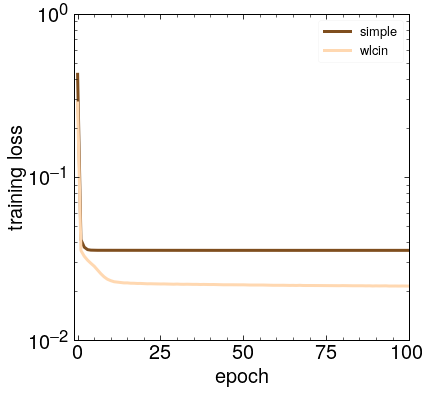

In [52]:
plt.figure(figsize=[6,6])
plt.semilogy()
plt.plot(history_baseline.history['loss'], c='xkcd:milk chocolate', linewidth=3, label='simple')
plt.plot(history_baseline_wlcin.history['loss'], c='xkcd:light peach', linewidth=3, label='wlcin')
plt.xlabel('epoch')
plt.xlim(-1,100)
plt.ylabel('training loss')
#plt.ylim(0.01,.5)
plt.legend()

In [53]:
pp['predict_base_E'] = np.exp(scaler_cal.inverse_transform(regressor_e.predict([pp.s_logE.to_numpy()])))
pp['predict_base_wlcin_E'] = np.exp(scaler_cal.inverse_transform(regressor_m.predict([pp[['s_logE','s_logEM','s_logCenter', 's_Density']].to_numpy()])))

2180/2180 [==============================] - 2s 1ms/step


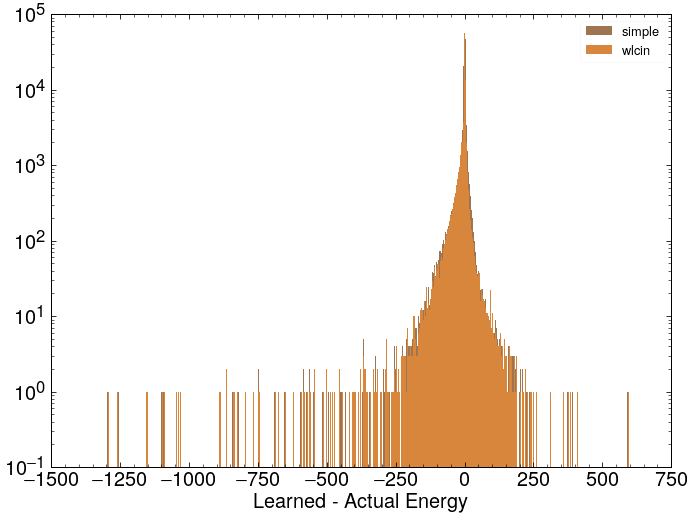

In [54]:
n_bins = 500
plt.hist(pp[pp.test].predict_base_E-pp[pp.test].cluster_ENG_CALIB_TOT,bins = n_bins, color='xkcd:mocha', label='simple')
plt.hist(pp[pp.test].predict_base_wlcin_E-pp[pp.test].cluster_ENG_CALIB_TOT,bins = n_bins, color='xkcd:dull orange', label='wlcin')
plt.yscale('log')
plt.xlabel('Learned - Actual Energy')
plt.legend() #just me or does it not seem any better...

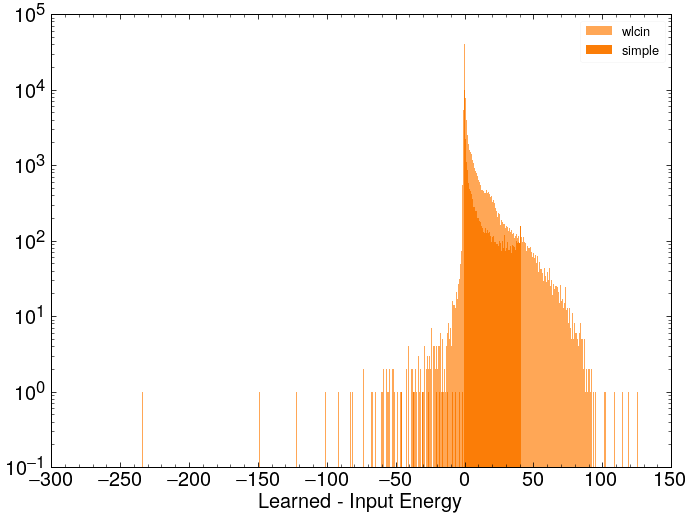

In [55]:
plt.hist(pp[pp.test].predict_base_wlcin_E-pp[pp.test].clusterE,bins = n_bins, color='xkcd:pale orange', label='wlcin')
plt.hist(pp[pp.test].predict_base_E-pp[pp.test].clusterE,bins = n_bins, color='xkcd:pumpkin orange', label='simple')
plt.yscale('log')
plt.xlabel('Learned - Input Energy')
plt.legend()

In [56]:
pp['predict_base_EoverCalib'] = pp.predict_base_E / pp.cluster_ENG_CALIB_TOT
pp['predict_base_wlcin_EoverCalib'] = pp.predict_base_wlcin_E / pp.cluster_ENG_CALIB_TOT

<Figure size 799.992x599.976 with 0 Axes>

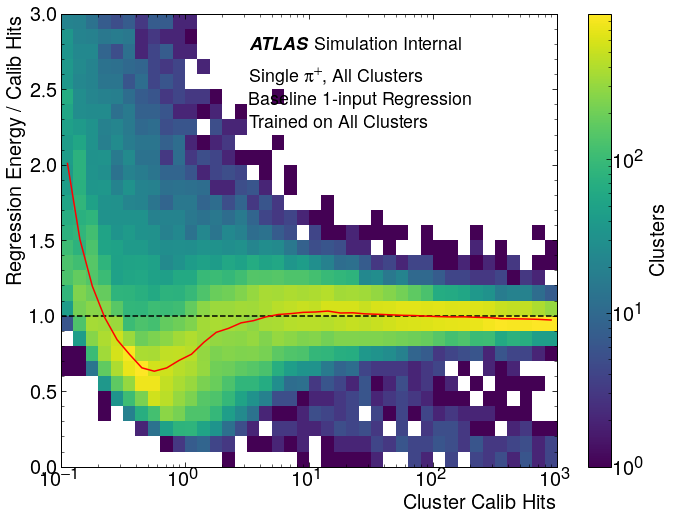

<Figure size 799.992x599.976 with 0 Axes>

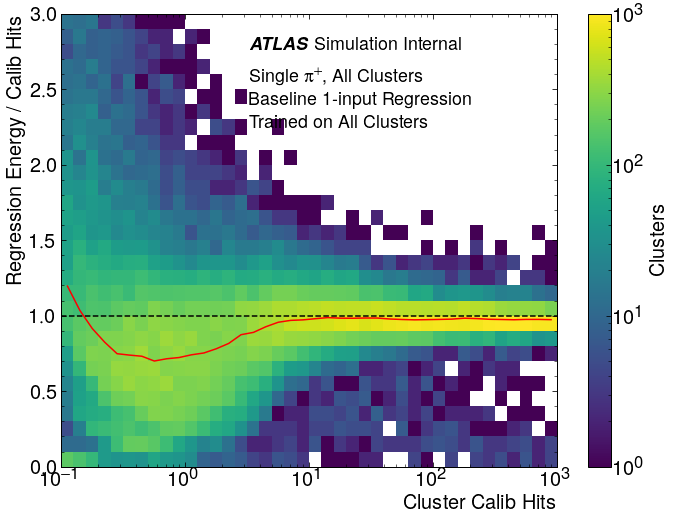

In [57]:
#for 100 nodes
xcenter, medReg = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                      pp[pp.test].predict_base_EoverCalib,
                      figfile = './hist_2D_calib_vs_ratioReg_pp_profile.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])
xcenterw, medRegw = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                      pp[pp.test].predict_base_wlcin_EoverCalib,
                      figfile = './hist_2D_calib_vs_ratioReg_pp_profile.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])


<Figure size 799.992x599.976 with 0 Axes>

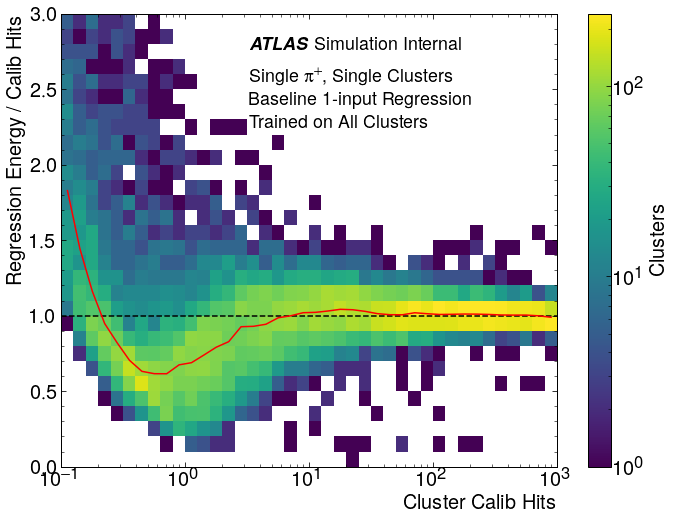

<Figure size 799.992x599.976 with 0 Axes>

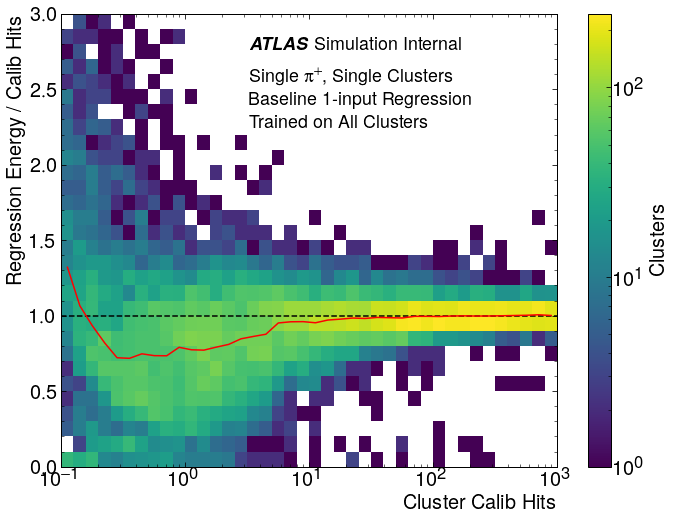

In [37]:
#for 100 nodes
xcenter, medRegSingle = ru.responsePlot(pp[pp.test & pp.Single].cluster_ENG_CALIB_TOT, 
                      pp[pp.test & pp.Single].predict_base_EoverCalib,
                      figfile = './hist_2D_calib_vs_ratioReg_pp_profile_Single.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, Single Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

xcenterw, medRegSinglew = ru.responsePlot(pp[pp.test & pp.Single].cluster_ENG_CALIB_TOT, 
                      pp[pp.test & pp.Single].predict_base_wlcin_EoverCalib,
                      figfile = './hist_2D_calib_vs_ratioReg_pp_profile_Single.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, Single Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

In [45]:
#by the response plots, can tell wlcin is better!

<Figure size 799.992x599.976 with 0 Axes>

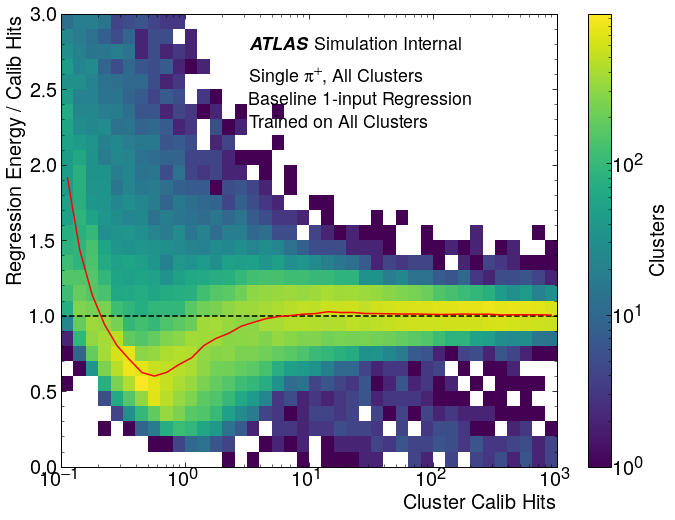

<Figure size 799.992x599.976 with 0 Axes>

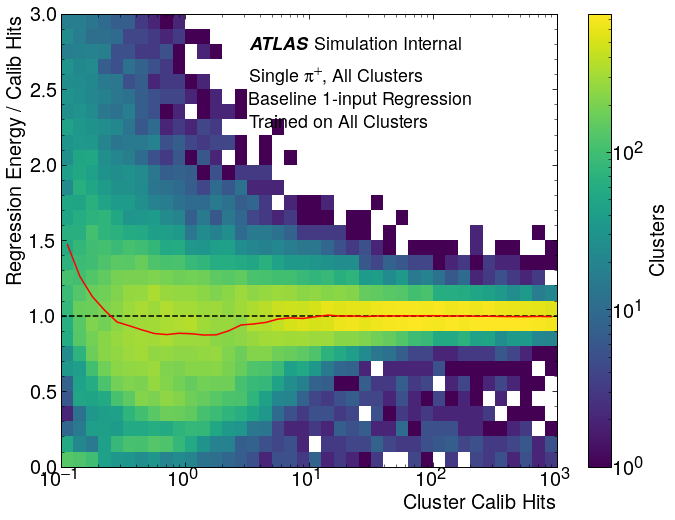

In [46]:
xcenter, medReg = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                      pp[pp.test].predict_base_EoverCalib,
                      figfile = './hist_2D_calib_vs_ratioReg_pp_profile.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])
xcenterw, medRegw = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                      pp[pp.test].predict_base_wlcin_EoverCalib,
                      figfile = './hist_2D_calib_vs_ratioReg_pp_profile.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])
#for 40 nodes, epoch of 200. less nodes better?!

<Figure size 799.992x599.976 with 0 Axes>

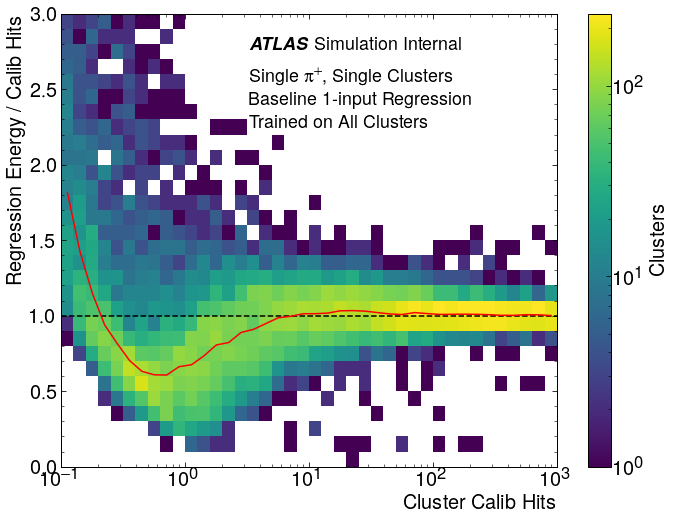

<Figure size 799.992x599.976 with 0 Axes>

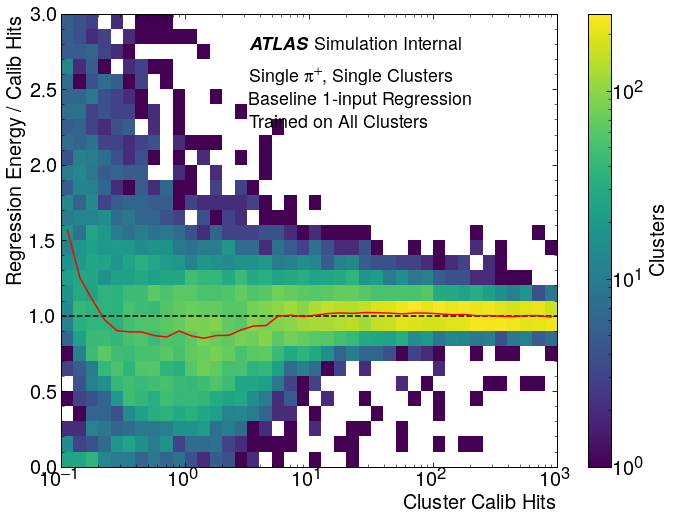

In [47]:
xcenter, medRegSingle = ru.responsePlot(pp[pp.test & pp.Single].cluster_ENG_CALIB_TOT, 
                      pp[pp.test & pp.Single].predict_base_EoverCalib,
                      figfile = './hist_2D_calib_vs_ratioReg_pp_profile_Single.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, Single Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

xcenterw, medRegSinglew = ru.responsePlot(pp[pp.test & pp.Single].cluster_ENG_CALIB_TOT, 
                      pp[pp.test & pp.Single].predict_base_wlcin_EoverCalib,
                      figfile = './hist_2D_calib_vs_ratioReg_pp_profile_Single.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, Single Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

<Figure size 799.992x599.976 with 0 Axes>

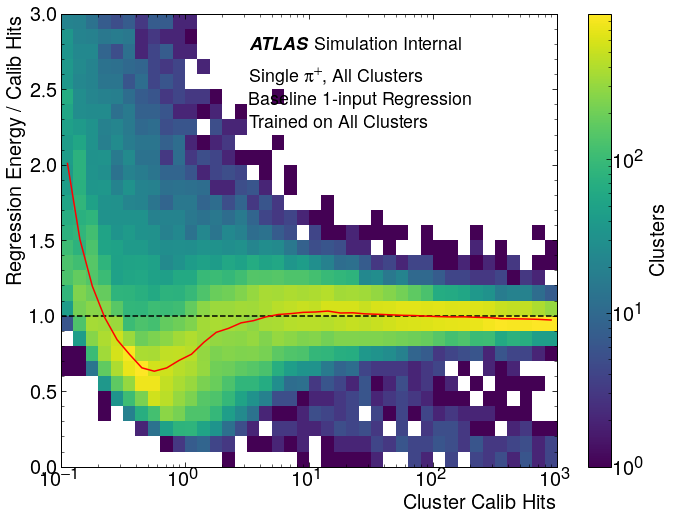

<Figure size 799.992x599.976 with 0 Axes>

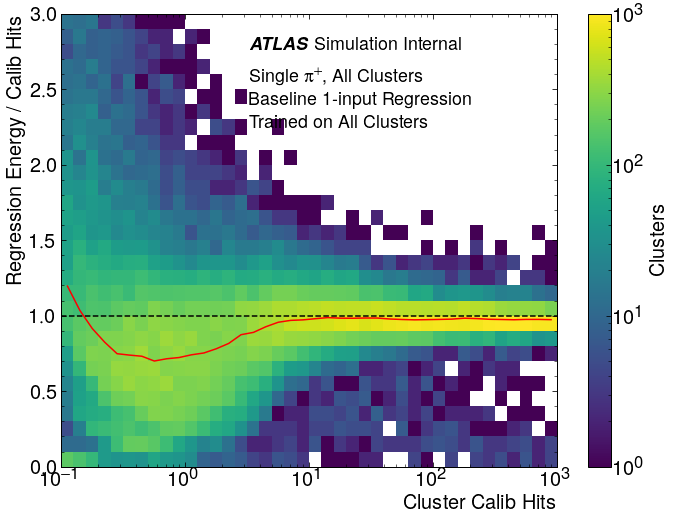

<Figure size 799.992x599.976 with 0 Axes>

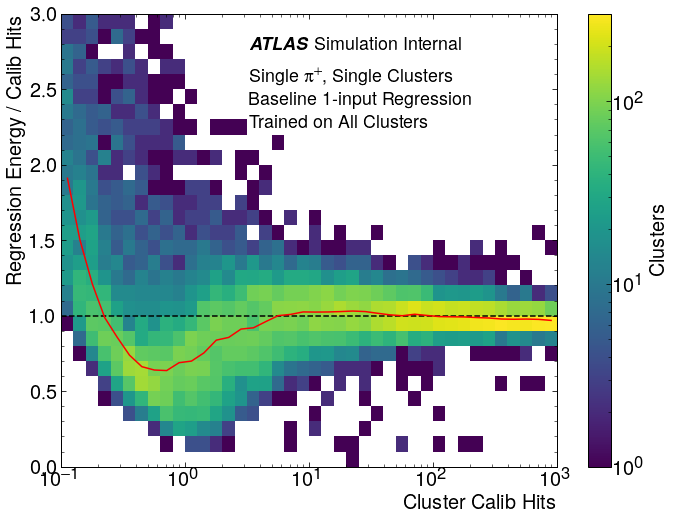

<Figure size 799.992x599.976 with 0 Axes>

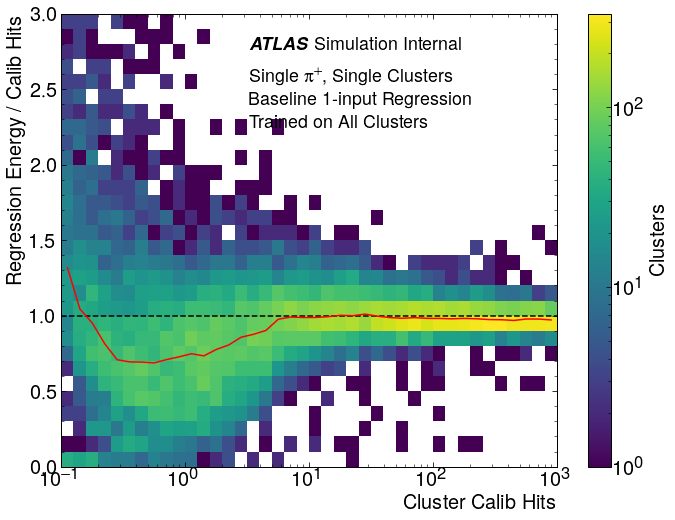

In [58]:
#try with 24 nodes - worse! best is around 40 then?
xcenter, medReg = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                      pp[pp.test].predict_base_EoverCalib,
                      figfile = './hist_2D_calib_vs_ratioReg_pp_profile.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])
xcenterw, medRegw = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                      pp[pp.test].predict_base_wlcin_EoverCalib,
                      figfile = './hist_2D_calib_vs_ratioReg_pp_profile.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

xcenter, medRegSingle = ru.responsePlot(pp[pp.test & pp.Single].cluster_ENG_CALIB_TOT, 
                      pp[pp.test & pp.Single].predict_base_EoverCalib,
                      figfile = './hist_2D_calib_vs_ratioReg_pp_profile_Single.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, Single Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

xcenterw, medRegSinglew = ru.responsePlot(pp[pp.test & pp.Single].cluster_ENG_CALIB_TOT, 
                      pp[pp.test & pp.Single].predict_base_wlcin_EoverCalib,
                      figfile = './hist_2D_calib_vs_ratioReg_pp_profile_Single.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, Single Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])